It's been reccomended that I switch from Buzzard v1.0 to 1.1. There's a nice catalog that actually has the richnesses and the masses. Huzzah.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from astropy.io import fits
dataDir = '/home/sean/Data/BuzzardSims/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_redmapper_v6.4.7_lgt-1_lambda_chisq_catalog.fit')

In [4]:
data = hdulist[1].data
data.columns.info()

name:
    ['HALOID', 'RA', 'DEC', 'Z', 'M200', 'R200', 'MEM_MATCH_ID', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'P_BCG', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD']
format:
    ['J', 'D', 'D', 'E', 'D', 'D', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'E', 'E', 'E', 'E', 'E', '3E', '3E', '4E', '21E', '21E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

In [41]:
import numpy as np
logMass = np.log10(data['M200'])
rich = data['LAMBDA_CHISQ']
logRich = np.log10(rich)

#sns.jointplot(rich, logMass, kind = 'kde', space = 0, stat_func = None)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


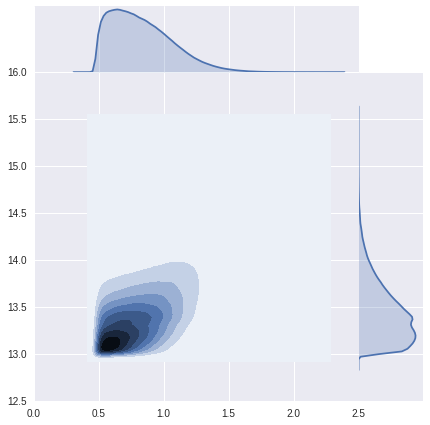

In [7]:
print 'Joint plot of Mass and Richness on a Log-Log Scale'
sns.jointplot(logRich, logMass, kind = 'kde', space = 0, stat_func = None)

Looking at the above plot, we see a few interesting things. Firstly, both richness and mass are heavily weighted at lower values. Secondly, the spread of values is pretty significant. Imaginging taking any 1-D slice along a richness value leaves almost an order of magnitude possible masses. I think it's somewhat clear that richness is a generally poor predictor of mass. 

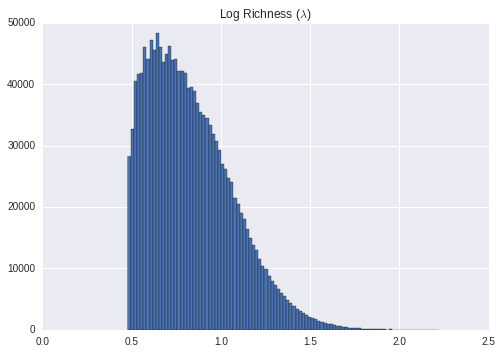

In [25]:
plt.hist(logRich, bins = 100);
plt.title('Log Richness ($\lambda$)')

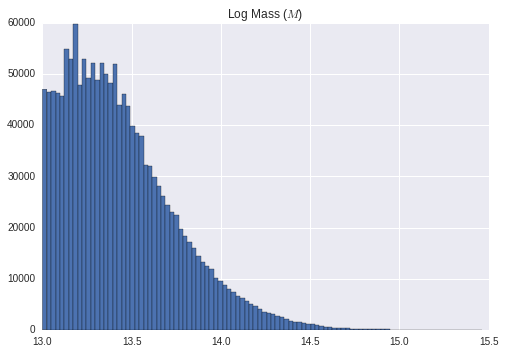

In [26]:
plt.hist(logMass, bins = 100);
plt.title('Log Mass ($M$)')

Mass seems to have a floor of 10^13 Solar masses, which seems reasonable but may have to be factored into the mass function. 

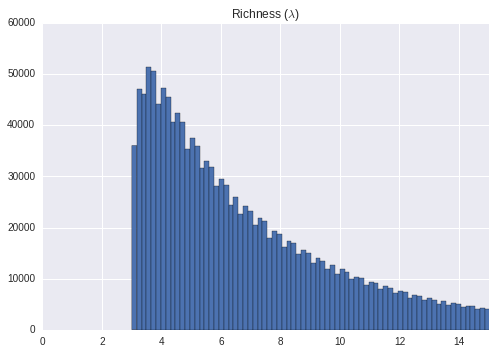

In [27]:
plt.hist(rich, bins = 1000);
plt.title('Richness ($\lambda$)')
plt.xlim(0,15);

Richness seems to be truncated at 3, which is much lower than the truncation at 20 in Buzzard 1.0. It seems like the distribution is going back down below ~4, which is interesting. I wonder what richness really means at low values. Does a lone galaxy in space really have a richness of 1? And though the distribution is fairly smooth, there is clearly some higher order structure. Let me blow that up a little bigger. 

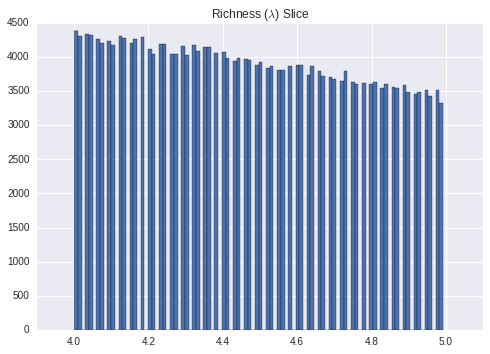

In [71]:
s1 = rich[rich>4.0]
s2 = s1[s1<5.0]
plt.hist(s2, bins = 100);
plt.title('Richness ($\lambda$) Slice')
plt.xlim(3.9,5.1);

Wow, that is some really weird structure. I have no idea if that's being exacerbated by the type of binning I'm doing. I also don't know if this is going to affect our analysis in any way. 

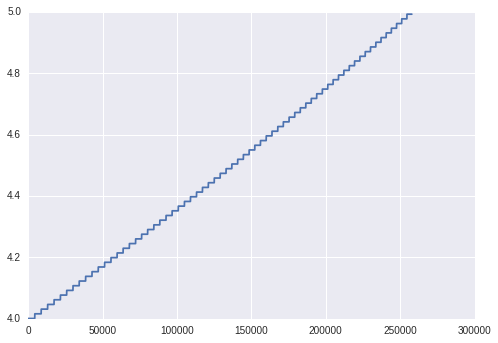

In [72]:
plt.plot(sorted(s2))

Well that explains it; it's just a resolution issue. Still may have to be accounted for because that shows up in weird ways. 

The simplest type of regression that we can do is a linear regression on the log space data. I do that below. The parameters a,b are for the model $\lambda =  a\;M^b$.

In [53]:
from scipy.stats import linregress
b, logA, r, p, err = linregress(logMass, logRich)
print 'a: %.3e\tb: %.3e'%(10**logA, b)
print 'R^2: %.3f'%r**2

a: 9.418e-05	b: 3.615e-01
R^2: 0.225


Somewhat what I expected. We have semi-reasonable values, but we're only accounting for 22% of our error. Those are some serious astronomy regression numbers. Let's see how it reproduces the distribution. 

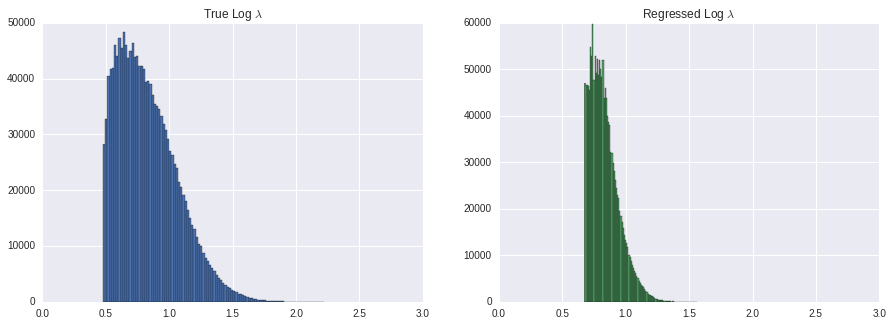

In [63]:
from itertools import cycle
palette = cycle(sns.color_palette())
#nBins = int(np.sqrt(rich.shape[0]))
nBins = 100
xlims = [0,3]
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('True Log $\lambda$')
plt.hist(logRich, bins = nBins, color = next(palette));
plt.xlim(xlims)
plt.subplot(122)
plt.title('Regressed Log $\lambda$')
A = 10**logA
plt.hist(logA+b*np.log10(data['M200']),bins = nBins, color = next(palette));
plt.xlim(xlims);

Approximately the same shape, but the scale's all wrong. Let's see if we can find that higher order structure from earlier. Note how I'm bumping up the bin size. 

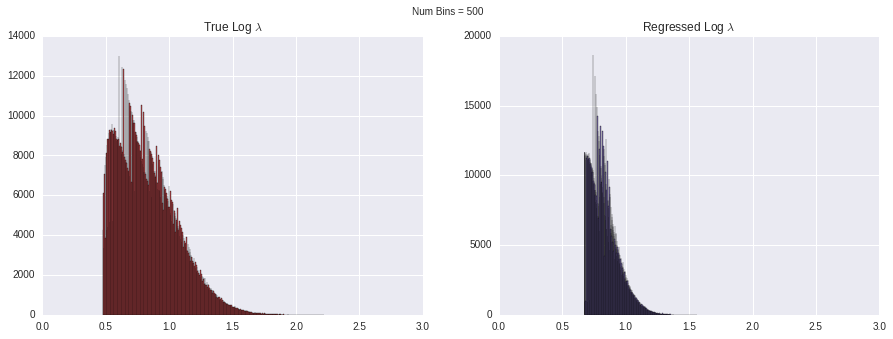

In [64]:
#nBins = int(np.sqrt(rich.shape[0]))
nBins = 500
xlims = [0,3]
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('True Log $\lambda$')
plt.hist(logRich, bins = nBins, color = next(palette));
plt.xlim(xlims)
plt.subplot(122)
plt.title('Regressed Log $\lambda$')
A = 10**logA
plt.hist(logA+b*np.log10(data['M200']),bins = nBins, color = next(palette));
plt.xlim(xlims);
plt.suptitle('Num Bins = %d'%nBins)

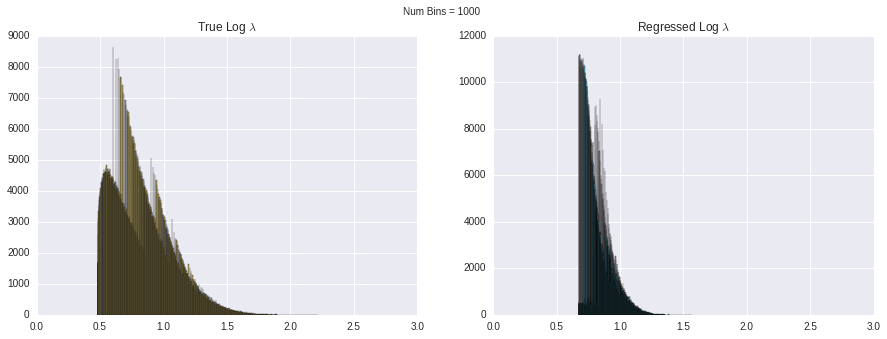

In [65]:
#nBins = int(np.sqrt(rich.shape[0]))
nBins = 1000
xlims = [0,3]
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('True Log $\lambda$')
plt.hist(logRich, bins = nBins, color = next(palette));
plt.xlim(xlims)
plt.subplot(122)
plt.title('Regressed Log $\lambda$')
A = 10**logA
plt.hist(logA+b*np.log10(data['M200']),bins = nBins, color = next(palette));
plt.xlim(xlims);
plt.suptitle('Num Bins = %d'%nBins)

Whoa. those are just straight weird looking. I think we might want to pause and thing about how this is affecting things. 